In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

In [3]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
yen_futures = pd.read_csv(
    Path("yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


In [30]:
# Trim the dataset to begin on January 1st, 1990
yen_futures = yen_futures.loc["1990-01-01":, :]
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336.0,51473.0
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206.0,53860.0
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0


In [31]:
returns = (yen_futures[["Settle"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()

In [32]:
returns.rename(columns = {'Settle':'Returns'}, inplace = True) 

In [57]:
joined=[yen_futures, returns]

In [58]:
df= pd.concat(joined, axis=1)

In [59]:
df['Lagged_Returns'] = df.Returns.shift()

In [60]:
df = df.replace(-np.inf, np.nan).dropna()

In [61]:
df.tail()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest,Returns,Lagged_Returns
Date,,,,,,,,,,
2019-10-09,9381.0,9391.5,9330.5,9343.5,38.5,9338.0,99153.0,145470.0,-0.410601,0.170931
2019-10-10,9343.5,9380.5,9293.5,9301.0,34.5,9303.5,159397.0,144474.0,-0.369458,-0.410601
2019-10-11,9308.5,9309.0,9240.0,9267.0,52.5,9251.0,158810.0,147471.0,-0.564304,-0.369458
2019-10-14,9259.0,9292.0,9250.5,9261.0,14.0,9265.0,69457.0,153902.0,0.151335,-0.564304
2019-10-15,9264.5,9280.0,9216.5,9220.0,43.5,9221.5,108342.0,151564.0,-0.469509,0.151335


## Train Test Split

In [66]:
# Create a train/test split for the data using 2018-2019 for testing and the rest for training
train = df[:'2017']
test = df['2018':]

In [67]:
# Create four dataframes:
# X_train (training set using just the independent variables), X_test (test set of of just the independent variables)
# Y_train (training set using just the "y" variable, i.e., "Futures Return"), Y_test (test set of just the "y" variable):
X_train = train["Lagged_Returns"].to_frame()
X_test = test["Lagged_Returns"].to_frame()
y_train = train["Returns"]
y_test = test["Returns"]

In [71]:
X_train.head()

,Lagged_Returns
Date,
2014-02-18,0.409123
2014-02-19,-0.427829
2014-02-20,-0.020460
2014-02-21,0.020465
2014-02-24,-0.204604


## Linear Regression Model

In [72]:
from sklearn.linear_model import LinearRegression

In [73]:
# Fit a SKLearn linear regression using just the training set (X_train, Y_train):
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [75]:
# And make a prediction of "y" values for just the test dataset
predictions = model.predict(X_test)

In [76]:
# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
Results = y_test.to_frame()
Results["Predicted Return"] = predictions

In [79]:
Results.head()

,Returns,Predicted Return
Date,,
2018-01-02,0.297285,-0.009599
2018-01-03,-0.240479,-0.010033
2018-01-04,-0.213028,-0.006807
2018-01-05,-0.353933,-0.006971
2018-01-08,0.062017,-0.006126


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fcca8ca8050>,
      dtype=object)

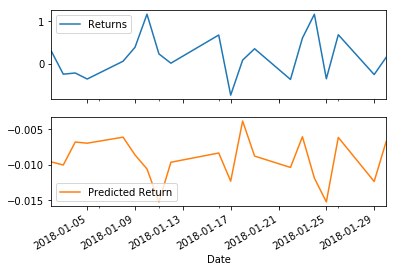

In [80]:
Results[:20].plot(subplots=True)

## Out-of-Sample Performance

In [82]:
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(
    Results["Returns"],
    Results["Predicted Return"]
)
rmse = np.sqrt(mse)
print(f"Out-of-Sample Root Mean Squared Error (RMSE): {rmse}")

Out-of-Sample Root Mean Squared Error (RMSE): 0.41545437184712763


## In-Sample Performance

In [84]:
in_sample_results = y_train.to_frame()

in_sample_results["In-sample Predictions"] = model.predict(X_train)

in_sample_mse = mean_squared_error(
    in_sample_results["Returns"],
    in_sample_results["In-sample Predictions"]
)

in_sample_rmse = np.sqrt(in_sample_mse)
print(f"In-sample Root Mean Squared Error (RMSE): {in_sample_rmse}")

In-sample Root Mean Squared Error (RMSE): 0.5962037920929946


Out of sample data (data that the model hasn't seen before) seem to have performed better than in-sample data (data that the model was trained on) as it has lower root mean squared error.